 ### Reboound 3 body problem

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import rebound
import numpy as np
import math
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy
from astropy.table import Table
import astropy.units as u

from tqdm import tqdm
import orbit_quantities
import matplotlib.gridspec as gspec
from scipy import optimize

In [17]:
G=astropy.constants.G.to(u.Msun**-1 * u.AU**3 * u.yr**-2).value

#Masses in solar mass
m0 = 100
m1 = 2
m2 = 1
M=m0+m1+m2


#Number of orbit before entering in the tidal radius
N=3
 

#Initial condition
ec_0=1                         #eccentricity of the binary CM orbit
rp_0=6                        #Distace at periapse of the CM


ab_0=1                           #Semi-major axis
eb_0=0.5                       #Eccentricity
phi_0=0                         #True anomaly

ib_0=0.5                      #Inclination
omega_0=0                      #Argument of periapsis
Omega_0=0                    #Longitude of the ascending node


t_0=orbit_quantities.initial_time(m0, m1, m2, ab_0, rp_0, ec_0, N)

def t_i(x, ec_0, t_0):
  if ec_0>1:
    t=np.sqrt(rp_0**3/(G*(m0+m1+m2)*(ec_0-1)**3))*(ec_0*np.sinh(x)-x)  
      
  elif ec_0<1:
    t=np.sqrt(rp_0**3/(G*(m0+m1+m2)*(1-ec_0)**3))*(x-ec_0*np.sin(x))
    
  else:
    t=np.sqrt(rp_0**3/(G*(m0+m1+m2)))*np.sqrt(2)*(x+x**3/3) 

  return t-t_0

if ec_0>1:
    zeta_0 = optimize.bisect(t_i, -1e3, 0, args=(ec_0, t_0))
    c_f_0 = (ec_0-np.cosh(zeta_0))/(ec_0*np.cosh(zeta_0)-1)
    s_f_0 = (np.sqrt(ec_0**2-1)*np.sinh(zeta_0))/(ec_0*np.cosh(zeta_0)-1)
    f_0 = np.arctan2(s_f_0,c_f_0)  
      
elif ec_0<1:
    eta_0 = optimize.bisect(t_i, -2*np.pi, 0, args=(ec_0, t_0))
    c_f_0 = (np.cos(eta_0)-ec_0)/(1-ec_0*np.cos(eta_0))
    s_f_0 = (np.sqrt(1-ec_0**2)*np.sin(eta_0))/(1-ec_0*np.cos(eta_0)) 
    f_0 = np.arctan2(s_f_0,c_f_0)  

else:
    t_f2_0 = optimize.bisect(t_i, -1e3, 0, args=(ec_0, t_0))
    f_0 = 2*np.arctan(t_f2_0)


r0, v0, r1, v1, r2, v2 = orbit_quantities.inertial_frame(m0, m1, m2, ab_0, eb_0, ib_0, Omega_0, omega_0, phi_0, rp_0, ec_0, f_0)
#orbit_quantities.orb_parameters(m0, m1, m2, r0[0], r0[1], r0[2], v0[0], v0[1], v0[2], r1[0], r1[1], r1[2], v1[0], v1[1], v1[2], r2[0], r2[1], r2[2], v2[0], v2[1], v2[2])

In [18]:
sim = rebound.Simulation()
#sim.integrator='janus'
sim.units=('Msun', 'yr', 'AU')
sim.G = astropy.constants.G.to(u.Msun**-1 * u.AU**3 * u.yr**-2).value 

sim.add(m=m0, x=r0[0], y=r0[1], z=r0[2], vx=v0[0], vy=v0[1], vz=v0[2])
sim.add(m=m1, x=r1[0], y=r1[1], z=r1[2], vx=v1[0], vy=v1[1], vz=v1[2])
sim.add(m=m2, x=r2[0], y=r2[1], z=r2[2], vx=v2[0], vy=v2[1], vz=v2[2])


t_r_v = Table(names=('t', r'r0x', r'r0y', r'r0z', r'v0x', r'v0y', r'v0z', r'r1x', r'r1y', r'r1z', r'v1x', r'v1y', r'v1z', r'r2x', r'r2y', r'r2z', r'v2x', r'v2y', r'v2z'))

def heartbeat(sim_pointer):
    sim = sim_pointer.contents
    p0=sim.particles[0]
    p1=sim.particles[1]
    p2=sim.particles[2]
    t_r_v.add_row((sim.t, p0.x, p0.y, p0.z, p0.vx, p0.vy, p0.vz, p1.x, p1.y, p1.z, p1.vx, p1.vy, p1.vz, p2.x, p2.y, p2.z, p2.vx, p2.vy, p2.vz ))


sim.heartbeat= heartbeat
sim.integrate(-2*t_0)

In [19]:
t_r_v

t,r0x,r0y,r0z,v0x,v0y,v0z,r1x,r1y,r1z,v1x,v1y,v1z,r2x,r2y,r2z,v2x,v2y,v2z
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,0.786726148263883,0.8198200545327138,-0.0,-0.3868404477567088,-0.1649220086068634,-0.0,-26.3908716087961,-27.32733515109046,0.0,12.894681591890294,-0.01650943199784738,-3.012262608205282,-25.8908716087961,-27.32733515109046,0.0,12.894681591890294,16.52521972468204,6.024525216410564
0.001,0.786339280871129,0.8196551044398472,1.81707939189198e-14,-0.3868943425575987,-0.16497818485895813,5.482792775077133e-11,-26.37789709326997,-27.327349862295822,-0.0030117870395272657,13.05431837811465,-0.012042747785487485,-3.01083614987268,-25.87813390057297,-27.310810719393082,0.006023574077237452,12.580797499530572,16.521903981466792,6.021672294262567
0.005,0.7847912719189326,0.8189947416091427,2.422399972657698e-12,-0.3871102106784043,-0.1652033545209685,1.489449778719304e-09,-26.324411622727688,-27.32728634816365,-0.015002235475860395,13.685477191903288,0.057384307056217124,-2.976968362257366,-25.830303946437887,-27.244901464586956,0.030004470709480792,11.340066684033856,16.40556683798442,5.953936575569754
0.009030192689947487,0.7832307041123094,0.8183284818291776,1.5080092628069298e-11,-0.38732817734698194,-0.16543097781535257,5.199414144387278e-09,-26.268019944149902,-27.326780537161536,-0.026858269373541577,14.29255878740264,0.20604204002643822,-2.8998572475927786,-25.787030522931143,-27.179287108594686,0.053716537239073894,10.147700159892915,16.131013701482384,5.799713975244143
0.013117842199049531,0.7816469896203682,0.8176517848001773,4.8450391252856315e-11,-0.3875497344761143,-0.16566262212194113,1.1586499759698246e-08,-26.208419350994664,-27.32550939641243,-0.03848607356813116,14.859156583780685,0.42641032671263995,-2.7836403974432864,-25.747860260047496,-27.114159687192874,0.0769721422912232,9.03666028005006,15.713441558768839,5.567279636236597
0.017295406977354995,0.7800275016596656,0.8169592225604885,1.1551514154266954e-10,-0.38777666949689754,-0.1659001720116719,2.1016196289195836e-08,-26.14524645322493,-27.323156022442106,-0.04981134358763923,15.372908531867362,0.7083976946890551,-2.6338657850663085,-25.712257259516708,-27.049610211164634,0.0996226756237643,8.031849885955033,15.173221811789084,5.267729468512988
0.021594207065568922,0.7783600243958639,0.8162455239472571,2.3224841385530525e-10,-0.3880107240991025,-0.16614547369951538,3.381063020342664e-08,-26.078161251767977,-27.3194092888217,-0.06076007304340103,15.825015917381975,1.0402916742736972,-2.456966172358398,-25.67967993605044,-26.985733817082316,0.12152012286196068,7.151040575146303,14.533964021404147,4.913928963653777
0.026045316659619865,0.7766324057251466,0.815505425259681,4.1814445067587417e-10,-0.3882536433803325,-0.16640038704306154,5.02387104282155e-08,-26.006833993457903,-27.31396290951877,-0.07126076087639702,16.210413987348574,1.4098512154396778,-2.259663268560473,-25.649572585598857,-26.92261670693055,0.14252147993834896,6.404536363336107,13.820336273426802,4.519321513249904
0.030680912322118004,0.7748320312535468,0.8147334430991805,6.968319323887831e-10,-0.3885072509060109,-0.16666686536930903,7.05058454257443e-08,-25.93092247767871,-27.30651201718058,-0.08124667796148487,16.527506869895852,1.805326285741093,-2.048412184889465,-25.621358169997258,-26.860320275556887,0.1624932862397765,5.795711350809387,13.056033965448721,4.096817319194387


In [7]:
ab, eb, ib, omega, Omega, rp, ec, Eb, Ec, phi, f = orbit_quantities.orb_parameters(m0, m1, m2, t_r_v['r0x'], t_r_v['r0y'], t_r_v['r0z'], t_r_v['v0x'], t_r_v['v0y'], t_r_v['v0z'], t_r_v['r1x'], t_r_v['r1y'], t_r_v['r1z'], t_r_v['v1x'], t_r_v['v1y'], t_r_v['v1z'], t_r_v['r2x'], t_r_v['r2y'], t_r_v['r2z'], t_r_v['v2x'], t_r_v['v2y'], t_r_v['v2z'])
#K0, U0, K1, U1, K2, U2 = orbit_quantities.single_energies(m0, m1, m2, t_r_v['r0x'], t_r_v['r0y'], t_r_v['r0z'], t_r_v['v0x'], t_r_v['v0y'], t_r_v['v0z'], t_r_v['r1x'], t_r_v['r1y'], t_r_v['r1z'], t_r_v['v1x'], t_r_v['v1y'], t_r_v['v1z'], t_r_v['r2x'], t_r_v['r2y'], t_r_v['r2z'], t_r_v['v2x'], t_r_v['v2y'], t_r_v['v2z'])
d = orbit_quantities.CM_distance(m0, m1, m2, t_r_v['r0x'], t_r_v['r0y'], t_r_v['r0z'], t_r_v['r1x'], t_r_v['r1y'], t_r_v['r1z'], t_r_v['r2x'], t_r_v['r2y'], t_r_v['r2z'])


#t_orb = Table([t_r_v['t']+t_0, ab, eb, ib, omega, Omega, phi, rp, ec, f, Eb, Ec, K0, U0, K1, U1, K2, U2, d], names=('t', 'ab', 'eb', 'ib', 'omega', 'Omega', 'phi', 'rp', 'ec', 'f', 'Eb', 'Ec', 'K0', 'U0', 'K1', 'U1', 'K2', 'U2', 'd'))


t_orb = Table([t_r_v['t']+t_0, ab, eb, ib, omega, Omega, phi, rp, ec, f, Eb, Ec, d], names=('t', 'ab', 'eb', 'ib', 'omega', 'Omega', 'phi', 'rp', 'ec', 'f', 'Eb', 'Ec', 'd'))


In [8]:
t_orb

t,ab,eb,ib,omega,Omega,phi,rp,ec,f,Eb,Ec,d
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-2.166684130454895,0.9999999999999997,0.49999999999999967,0.5,0.0,0.0,0.0,4.62620231354269,1.0000000000000002,-2.448506054238526,-39.47692640889764,2.8421709430404007e-13,39.01093109039331
-2.165684130454895,1.0000139625640627,0.500006988978166,0.4999987047142963,-2.3039449015507533e-06,-5.122536923716714e-08,0.03769484125397991,5.999998749534112,1.0000000003280307,-2.3354528907553878,-39.476375217479685,3.237411760892428e-07,38.99764864317851
-2.161684130454895,1.000068601091492,0.5000345487894902,0.49999311725192774,-1.148720878482645e-05,-1.3908271184361824e-06,0.1877677063637929,5.999998468934959,1.0000000074087574,-2.3348711184612223,-39.47421843442723,7.3118761179102876e-06,38.94450033422083
-2.1576539377649473,1.000119273502539,0.5000606345822993,0.4999869685348503,-2.0915832337696865e-05,-4.8524581543904375e-06,0.3361831175206287,5.9999972008994344,1.0000000239969344,-2.3342834131905463,-39.47221841915379,2.3683141421315668e-05,38.89092083557936
-2.1535662882558455,1.0001632589491638,0.500084152293068,0.49998041150273237,-3.149135486733378e-05,-1.0807271675932339e-05,0.4818472729510154,5.999996131173069,1.0000000502215474,-2.3336856452226336,-39.47048249940178,4.956484019658092e-05,38.836546631512526
-2.1493887234775397,1.0001981573043155,0.500104231860466,0.4999736118818688,-4.4683302082004104e-05,-1.9591615511120258e-05,0.6240078083713694,5.999995212620227,1.0000000859464657,-2.3330729732197173,-39.46910531738419,8.482262524012185e-05,38.780944202298144
-2.145089923389326,1.0002218616114449,0.5001202257103593,0.4999667587023095,-6.236927433757354e-05,-3.150047427526257e-05,0.762038275571236,5.9999945837411905,1.0000001307097837,-2.332440651761146,-39.468169937114595,0.0001290006292151702,38.723694137548925
-2.140638813795275,1.0002326189224102,0.5001317396957355,0.499960063822754,-8.667130107393581e-05,-4.677834030614322e-05,0.8954774021895636,5.999994282457223,1.0000001836594157,-2.331783920422841,-39.467745464477716,0.00018125790364820205,38.66437921507558
-2.136003218132777,1.0002290696094915,0.5001386418800531,0.4999537594131222,-0.00011978901604949053,-6.560971489327139e-05,1.0240584758719078,5.99999439946408,1.0000002434876085,-2.331097787276343,-39.467885515775066,0.00024030378438055777,38.60256634088741


[Text(0, -40.0, ''),
 Text(0, -30.0, ''),
 Text(0, -20.0, ''),
 Text(0, -10.0, ''),
 Text(0, 0.0, ''),
 Text(0, 10.0, ''),
 Text(0, 20.0, ''),
 Text(0, 30.0, ''),
 Text(0, 40.0, ''),
 Text(0, 50.0, '')]

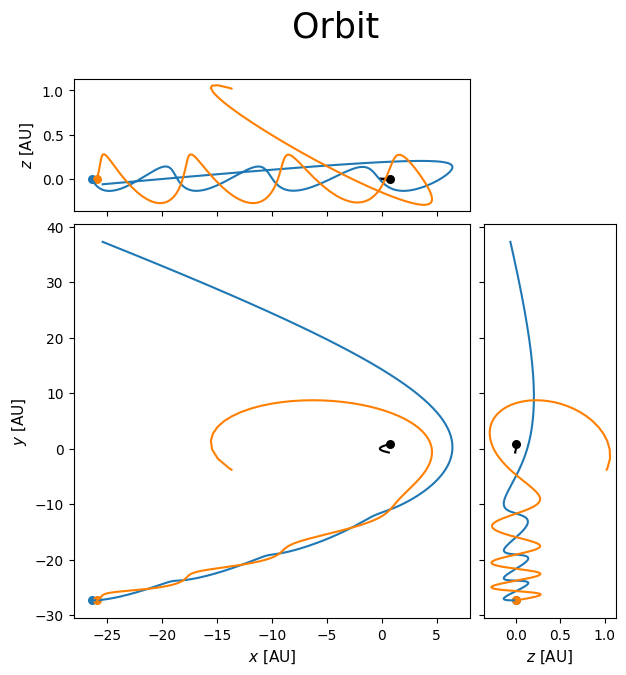

In [10]:
fig = plt.figure(figsize =[7,7])
fig.suptitle("Orbit", fontsize = 25)
gs = gspec.GridSpec(nrows=2, ncols=2, width_ratios=(3, 1), height_ratios=(1, 3), hspace=0.05, wspace=0.05)

rcx, rcy, rcz= orbit_quantities.CM_r(m1, m2, t_r_v['r1x'], t_r_v['r1y'], t_r_v['r1z'], t_r_v['r2x'], t_r_v['r2y'], t_r_v['r2z'])


ax1 = plt.subplot(gs[0])
ax1.plot(t_r_v['r0x'], t_r_v['r0z'], label=r'$0$', color='black')
ax1.scatter(t_r_v['r0x'][0], t_r_v['r0z'][0], s=30, color='black')
ax1.plot(t_r_v['r1x'], t_r_v['r1z'], label=r'$1$', color=plt.cm.Paired(1))
ax1.scatter(t_r_v['r1x'][0], t_r_v['r1z'][0], s=30, color=plt.cm.Paired(1))
ax1.plot(t_r_v['r2x'], t_r_v['r2z'], label=r'$2$', color=plt.cm.Paired(7))
ax1.scatter(t_r_v['r2x'][0], t_r_v['r2z'][0], s=30, color=plt.cm.Paired(7))
#ax1.plot(rcx, rcz, label=r'$0$')
#ax1.scatter(rcx[0], rcz[0], s=30)
ax1.set_ylabel(r"$z\ \mathrm{[AU]}$", fontsize = 11)
ax1.set_xticklabels([])

ax2 = plt.subplot(gs[2])
ax2.plot(t_r_v['r0x'], t_r_v['r0y'], label=r'$0$', color='black')
ax2.scatter(t_r_v['r0x'][0], t_r_v['r0y'][0], s=30, color='black')
ax2.plot(t_r_v['r1x'], t_r_v['r1y'], label=r'$1$', color=plt.cm.Paired(1))
ax2.scatter(t_r_v['r1x'][0], t_r_v['r1y'][0], s=30, color=plt.cm.Paired(1))
ax2.plot(t_r_v['r2x'], t_r_v['r2y'], label=r'$2$', color=plt.cm.Paired(7))
ax2.scatter(t_r_v['r2x'][0], t_r_v['r2y'][0], s=30, color=plt.cm.Paired(7))
#ax2.plot(rcx, rcy, label=r'$0$')
#ax2.scatter(rcx[0], rcy[0], s=30)
ax2.set_xlabel(r"$x\ \mathrm{[AU]}$", fontsize = 11)
ax2.set_ylabel(r"$y\ \mathrm{[AU]}$", fontsize = 11)

ax3 = plt.subplot(gs[3])
ax3.plot(t_r_v['r0z'], t_r_v['r0y'], label=r'$0$', color='black')
ax3.scatter(t_r_v['r0z'][0], t_r_v['r0y'][0], s=30, color='black')
ax3.plot(t_r_v['r1z'], t_r_v['r1y'], label=r'$1$', color=plt.cm.Paired(1))
ax3.scatter(t_r_v['r1z'][0], t_r_v['r1y'][0], s=30, color=plt.cm.Paired(1))
ax3.plot(t_r_v['r2z'], t_r_v['r2y'], label=r'$2$', color=plt.cm.Paired(7))
ax3.scatter(t_r_v['r2z'][0], t_r_v['r2y'][0], s=30, color=plt.cm.Paired(7))
#ax3.plot(rcz, rcy, label=r'$0$')
#ax3.scatter(rcz[0], rcy[0], s=30)
ax3.set_xlabel(r"$z\ \mathrm{[AU]}$", fontsize = 11)
ax3.set_yticklabels([])


#fig.savefig('orbit_plot.pdf', format='pdf')

In [11]:
# save the XYZ position, velocities and time of the particles to a file
t_r_v.write('orbit_data.txt', format='ascii', overwrite=True)

# Now do fixed time steps for manim

In [42]:
t_r_v = 0

In [43]:

t_r_v = Table(names=('t', r'r0x', r'r0y', r'r0z', r'v0x', r'v0y', r'v0z', r'r1x', r'r1y', r'r1z', r'v1x', r'v1y', r'v1z', r'r2x', r'r2y', r'r2z', r'v2x', r'v2y', r'v2z'))


# --- Modify heartbeat to accept the simulation directly ---
def heartbeat(sim):
    p0 = sim.particles[0]
    p1 = sim.particles[1]
    p2 = sim.particles[2]
    t_r_v.add_row((sim.t, p0.x, p0.y, p0.z, p0.vx, p0.vy, p0.vz,
                   p1.x, p1.y, p1.z, p1.vx, p1.vy, p1.vz,
                   p2.x, p2.y, p2.z, p2.vx, p2.vy, p2.vz))

# --- Set up a fixed-step integrator ---
sim.integrator = "whfast"

# Define fixed time grid parameters: 1000 steps from t_start=0 to t_end=-2*t_0
num_steps = 10000
t_start = 0.0
t_end = -5 * t_0
times = np.linspace(t_start, t_end, num_steps)

# Set the fixed time step in the integrator
sim.dt = (t_end - t_start) / num_steps

# --- Run the simulation ---
for t in times:
    sim.integrate(t)
    heartbeat(sim)

In [31]:
t_r_v.write('orbit_data_finner.txt', format='ascii', overwrite=True)

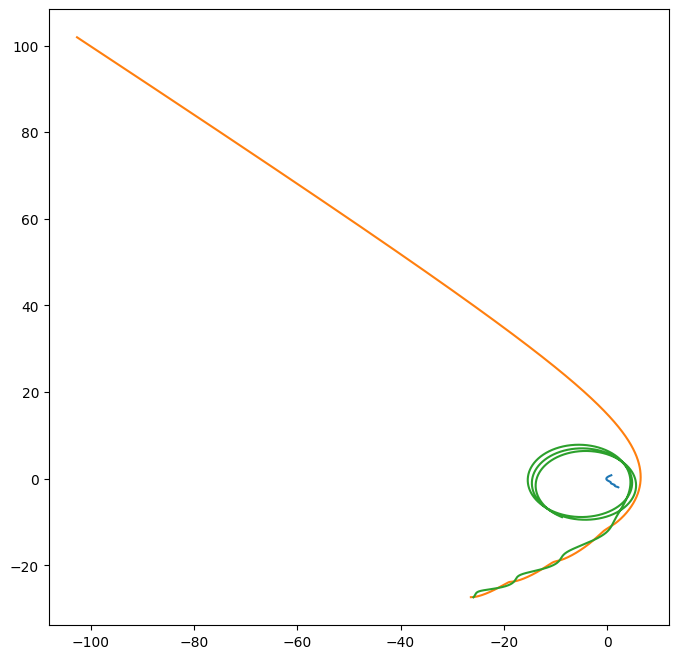

In [32]:
# plot the orbit
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(t_r_v['r0x'], t_r_v['r0y'], label='0')
ax.plot(t_r_v['r1x'], t_r_v['r1y'], label='1')
ax.plot(t_r_v['r2x'], t_r_v['r2y'], label='2')


# Binary Black hole

In [95]:
G=astropy.constants.G.to(u.Msun**-1 * u.AU**3 * u.yr**-2).value

#Masses in solar mass
m0 = 1
m1 = 1e6
m2 = 1e3
M=m0+m1+m2


#Number of orbit before entering in the tidal radius
N=10
 

#Initial condition
ec_0=1                         #eccentricity of the binary CM orbit
rp_0=50                        #Distace at periapse of the CM


ab_0=40                           #Semi-major axis
eb_0=1e-6                       #Eccentricity
phi_0=0                         #True anomaly

ib_0=0.5                      #Inclination
omega_0=0                      #Argument of periapsis
Omega_0=0                    #Longitude of the ascending node


t_0=orbit_quantities.initial_time(m0, m1, m2, ab_0, rp_0, ec_0, N)

def t_i(x, ec_0, t_0):
  if ec_0>1:
    t=np.sqrt(rp_0**3/(G*(m0+m1+m2)*(ec_0-1)**3))*(ec_0*np.sinh(x)-x)  
      
  elif ec_0<1:
    t=np.sqrt(rp_0**3/(G*(m0+m1+m2)*(1-ec_0)**3))*(x-ec_0*np.sin(x))
    
  else:
    t=np.sqrt(rp_0**3/(G*(m0+m1+m2)))*np.sqrt(2)*(x+x**3/3) 

  return t-t_0

if ec_0>1:
    zeta_0 = optimize.bisect(t_i, -1e3, 0, args=(ec_0, t_0))
    c_f_0 = (ec_0-np.cosh(zeta_0))/(ec_0*np.cosh(zeta_0)-1)
    s_f_0 = (np.sqrt(ec_0**2-1)*np.sinh(zeta_0))/(ec_0*np.cosh(zeta_0)-1)
    f_0 = np.arctan2(s_f_0,c_f_0)  
      
elif ec_0<1:
    eta_0 = optimize.bisect(t_i, -2*np.pi, 0, args=(ec_0, t_0))
    c_f_0 = (np.cos(eta_0)-ec_0)/(1-ec_0*np.cos(eta_0))
    s_f_0 = (np.sqrt(1-ec_0**2)*np.sin(eta_0))/(1-ec_0*np.cos(eta_0)) 
    f_0 = np.arctan2(s_f_0,c_f_0)  

else:
    t_f2_0 = optimize.bisect(t_i, -1e3, 0, args=(ec_0, t_0))
    f_0 = 2*np.arctan(t_f2_0)


r0, v0, r1, v1, r2, v2 = orbit_quantities.inertial_frame(m0, m1, m2, ab_0, eb_0, ib_0, Omega_0, omega_0, phi_0, rp_0, ec_0, f_0)
#orbit_quantities.orb_parameters(m0, m1, m2, r0[0], r0[1], r0[2], v0[0], v0[1], v0[2], r1[0], r1[1], r1[2], v1[0], v1[1], v1[2], r2[0], r2[1], r2[2], v2[0], v2[1], v2[2])

In [76]:
t_r_v = 0

In [77]:
t_0

np.float64(-0.5801658436992227)

In [57]:

sim = rebound.Simulation()
#sim.integrator='janus'
sim.units=('Msun', 'yr', 'AU')
sim.G = astropy.constants.G.to(u.Msun**-1 * u.AU**3 * u.yr**-2).value 

sim.add(m=m0, x=r0[0], y=r0[1], z=r0[2], vx=v0[0], vy=v0[1], vz=v0[2])
sim.add(m=m1, x=r1[0], y=r1[1], z=r1[2], vx=v1[0], vy=v1[1], vz=v1[2])
sim.add(m=m2, x=r2[0], y=r2[1], z=r2[2], vx=v2[0], vy=v2[1], vz=v2[2])



t_r_v = Table(names=('t', r'r0x', r'r0y', r'r0z', r'v0x', r'v0y', r'v0z', r'r1x', r'r1y', r'r1z', r'v1x', r'v1y', r'v1z', r'r2x', r'r2y', r'r2z', r'v2x', r'v2y', r'v2z'))


# --- Modify heartbeat to accept the simulation directly ---
def heartbeat(sim):
    p0 = sim.particles[0]
    p1 = sim.particles[1]
    p2 = sim.particles[2]
    t_r_v.add_row((sim.t, p0.x, p0.y, p0.z, p0.vx, p0.vy, p0.vz,
                   p1.x, p1.y, p1.z, p1.vx, p1.vy, p1.vz,
                   p2.x, p2.y, p2.z, p2.vx, p2.vy, p2.vz))

# --- Set up a fixed-step integrator ---
sim.integrator = "whfast"

# Define fixed time grid parameters: 1000 steps from t_start=0 to t_end=-2*t_0
num_steps = 10000
t_start = 0.0
t_end = -10
times = np.linspace(t_start, t_end, num_steps)

# Set the fixed time step in the integrator
sim.dt = (t_end - t_start) / num_steps

# --- Run the simulation ---
for t in times:
    sim.integrate(t)
    heartbeat(sim)

In [96]:
sim = rebound.Simulation()
#sim.integrator='janus'
sim.units=('Msun', 'yr', 'AU')
sim.G = astropy.constants.G.to(u.Msun**-1 * u.AU**3 * u.yr**-2).value 

sim.add(m=m0, x=r0[0], y=r0[1], z=r0[2], vx=v0[0], vy=v0[1], vz=v0[2])
sim.add(m=m1, x=r1[0], y=r1[1], z=r1[2], vx=v1[0], vy=v1[1], vz=v1[2])
sim.add(m=m2, x=r2[0], y=r2[1], z=r2[2], vx=v2[0], vy=v2[1], vz=v2[2])


t_r_v = Table(names=('t', r'r0x', r'r0y', r'r0z', r'v0x', r'v0y', r'v0z', r'r1x', r'r1y', r'r1z', r'v1x', r'v1y', r'v1z', r'r2x', r'r2y', r'r2z', r'v2x', r'v2y', r'v2z'))

def heartbeat(sim_pointer):
    sim = sim_pointer.contents
    p0=sim.particles[0]
    p1=sim.particles[1]
    p2=sim.particles[2]
    t_r_v.add_row((sim.t, p0.x, p0.y, p0.z, p0.vx, p0.vy, p0.vz, p1.x, p1.y, p1.z, p1.vx, p1.vy, p1.vz, p2.x, p2.y, p2.z, p2.vx, p2.vy, p2.vz ))


sim.heartbeat= heartbeat
sim.integrate(15)

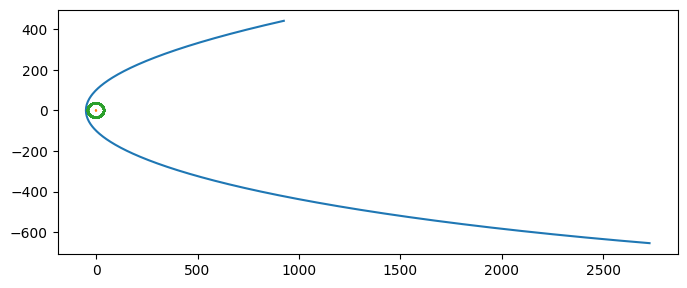

In [100]:
# plot the orbit
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
#ax.set_autoscale_on(True)
# set same scale for both axis
ax.set_aspect('equal')
ax.plot(t_r_v['r0x'], t_r_v['r0y'], label='0')
ax.plot(t_r_v['r1x'], t_r_v['r1y'], label='1')
ax.plot(t_r_v['r2x'], t_r_v['r2y'], label='2')


In [101]:
t_r_v.write('orbit_data_binary_bh.txt', format='ascii', overwrite=True)